In [1]:
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(stringr))
library(hise)
library(plyr)
library(purrr)
library(vegan)
#library(arrow)
library(rstatix)
library(parallel)
library(ggpubr)
library(ComplexHeatmap)
library(ggsci)
library(ggrepel)

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



Attaching package: ‘purrr’


The following object is masked from ‘package:plyr’:

    compact


Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4


Attaching package: ‘rstatix’


The following objects are masked from ‘package:plyr’:

    desc, mutate


The following object is masked from ‘package:stats’:

    filter


Loading required package: ggplot2


Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    muta

In [2]:

colors = c('#FDC086','#FFFF99','#F0027F','#BF5B17','#666666',
          '#1B9E77','#D95F02','#7570B3','#E7298A','#66A61E','#E6AB02','#A6761D','#666666',
          '#A6CEE3','#1F78B4','#B2DF8A','#33A02C','#FB9A99','#E31A1C','#FDBF6F','#FF7F00',
          '#CAB2D6','#6A3D9A','#FFFF99','#B15928','#FBB4AE','#B3CDE3','#CCEBC5','#DECBE4',
          '#FED9A6','#FFFFCC','#E5D8BD','#FDDAEC','#F2F2F2','#B3E2CD','#FDCDAC','#CBD5E8',
          '#F4CAE4','#E6F5C9','#FFF2AE','#F1E2CC','#CCCCCC','#E41A1C','#377EB8','#4DAF4A',
          '#984EA3','#FF7F00','#FFFF33','#A65628','#F781BF','#999999','#66C2A5','#FC8D62',
          '#8DA0CB','#E78AC3','#A6D854','#FFD92F','#E5C494','#B3B3B3','#8DD3C7','#FFFFB3',
          '#BEBADA','#FB8072','#80B1D3','#FDB462','#B3DE69','#FCCDE5','#D9D9D9','#BC80BD',
          '#CCEBC5','#FFED6F')

In [3]:

clr_transform <- function(x) {
  if (length(x) == 0) {
    return(NA)  # return NA for empty vectors
  }
  geom_mean <- exp(mean(log(x)))
  return(log(x / geom_mean))
}

# Labels

In [4]:
label<-read.csv('Reference_Label.csv')
label<-label %>% filter(!cohort.cohortGuid=='UP1')

# BR1 VS BR2

In [116]:
result <- label %>%
  dplyr::group_by(AIFI_L3, subject.subjectGuid) %>%               
  dplyr::summarise(count = n()) %>%                  # Count occurrences
  dplyr::group_by(subject.subjectGuid) %>%                       
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>% 
  dplyr::group_by(subject.subjectGuid) %>%     
  dplyr::mutate(percentage_clr = clr_transform((percentage))) %>% # Group again by subjectGuid for CLR# Calculate percentage
  dplyr::ungroup() %>% as.data.frame(.)

head(result)

`summarise()` has grouped output by 'AIFI_L3'. You can override using the
`.groups` argument.


,AIFI_L3,subject.subjectGuid,count,percentage,percentage_clr
,<chr>,<chr>,<int>,<dbl>,<dbl>
1,ASDC,BR1001,6,0.03236770,-2.232976
2,ASDC,BR1002,5,0.02637409,-2.242500
3,ASDC,BR1003,4,0.02094680,-2.763896
4,ASDC,BR1004,3,0.01710571,-2.626914
5,ASDC,BR1005,5,0.02809620,-1.943233
6,ASDC,BR1006,4,0.02300966,-2.337902


## get median per cohorts

In [117]:
meta<-unique(label[c('subject.subjectGuid','cohort.cohortGuid','CMV.IgG.Serology.Result.Interpretation')])

In [118]:
result<-left_join(result,meta)

Joining with `by = join_by(subject.subjectGuid)`


In [119]:
mean_per_group <- result %>%
  group_by(cohort.cohortGuid,AIFI_L3) %>%
  dplyr::summarize(median_value = median(percentage))


`summarise()` has grouped output by 'cohort.cohortGuid'. You can override using
the `.groups` argument.


In [120]:
mean_per_group_BR1<-mean_per_group %>% filter(cohort.cohortGuid=="BR1") %>% arrange(AIFI_L3)
mean_per_group_BR2<-mean_per_group %>% filter(cohort.cohortGuid=="BR2") %>% arrange(AIFI_L3)

In [121]:
mean_per_group_BR1$AIFI_L3==mean_per_group_BR2$AIFI_L3

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

In [122]:
log2FC=as.data.frame(log2(mean_per_group_BR1$median_value/mean_per_group_BR2$median_value))
log2FC$AIFI_L3<-mean_per_group_BR1$AIFI_L3

## get DEG numbers

In [123]:
levels='L3'
file_list<-list.files(path = paste0("./02B_DESeq2_BR1_VS_BR2_",levels), pattern = ".csv", all.files = FALSE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = FALSE, include.dirs = TRUE, no.. = FALSE)

In [124]:
DEG_list<-mclapply(file_list,read.csv,mc.cores=length(file_list))
DEG<-do.call(rbind,DEG_list)

In [125]:
DEG<- DEG%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.1 ~ "Up-regulated",
                                                     log2FoldChange <= -0.1 & padj <= 0.1 ~ "Down-regulated",
                                                     TRUE ~ "Unchanged"))

In [126]:
freq <- DEG %>% dplyr::mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.1 ~ "Up-regulated-BR1",
                                                     log2FoldChange <= -0.1 & padj <= 0.1 ~ "Down-regulated-BR1",
                                                     TRUE ~ "Unchanged")) %>% filter(!Expression=='Unchanged')%>%
  dplyr::group_by(celltype) %>%
  dplyr::summarise(count = n())


In [127]:
colnames(freq)[1]<-"AIFI_L3"

## Plotting

In [128]:
Celltypt_dict<-read.csv('cell_types.csv')
colnames(Celltypt_dict)<-c('AIFI_L1','AIFI_L2','AIFI_L3')

In [129]:
log2FC<-left_join(log2FC,freq) %>%
  mutate_all(~replace(., is.na(.), 0))

Joining with `by = join_by(AIFI_L3)`


In [130]:
colnames(log2FC)[1]<-"Log2FC(BR1/BR2)"

In [131]:
log2FC<-left_join(log2FC,Celltypt_dict)

Joining with `by = join_by(AIFI_L3)`


In [132]:
log2FC$log_counts <- ifelse(log2FC$count == 0, -1, log2(log2FC$count))

Warning message:
“ggrepel: 26 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


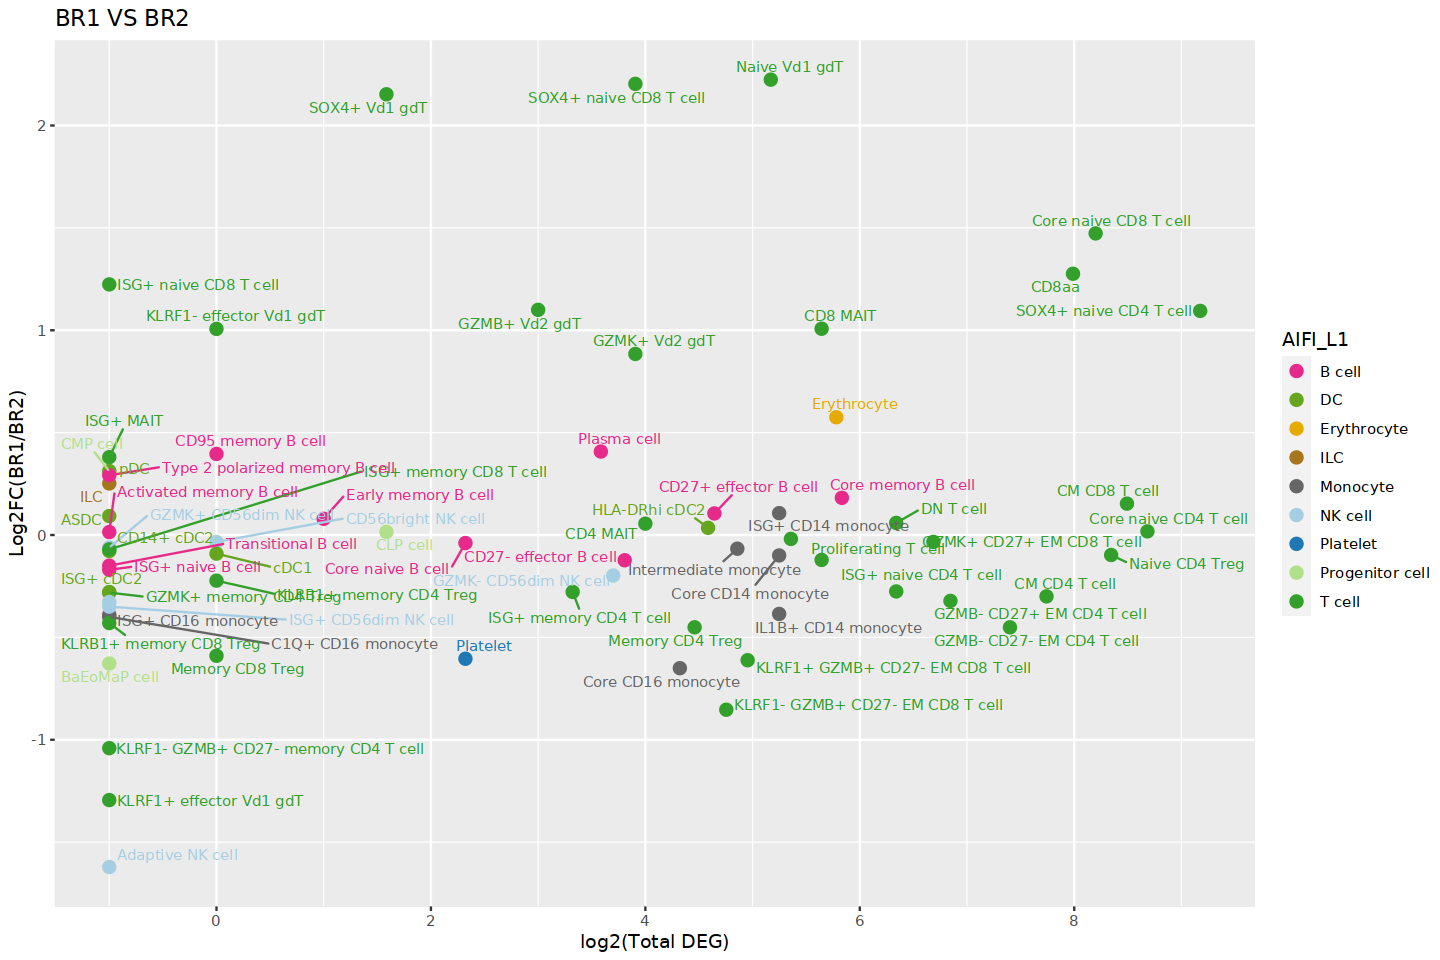

In [134]:
options(repr.plot.width = 12, repr.plot.height = 8)

ggplot(log2FC, aes(`log_counts`, `Log2FC(BR1/BR2)`,  color = AIFI_L1),) +
  geom_point(size=3)+ geom_text_repel(aes(label = AIFI_L3,  color = AIFI_L1), size =3)+
xlab('Total DEG')+scale_color_manual(values = colors[9:19])+ggtitle("BR1 VS BR2")+xlab('log2(Total DEG)')+ 
  scale_x_continuous(breaks = function(x) unique(floor(pretty(seq(min(x), (max(x) + 1) * 1.1)))))


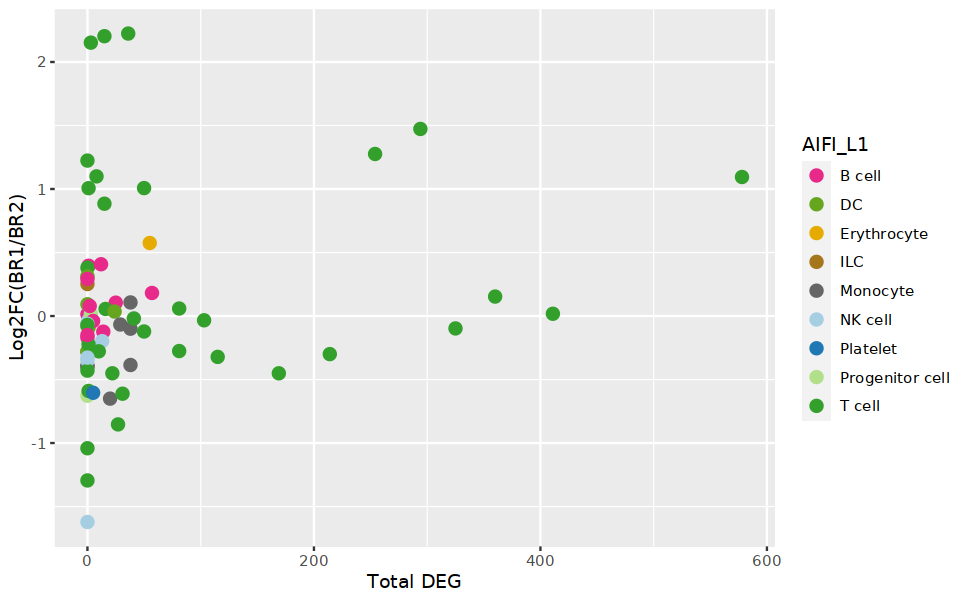

In [73]:
options(repr.plot.width = 8, repr.plot.height = 5)

ggplot(log2FC, aes(`count`, `Log2FC(BR1/BR2)`,  color = AIFI_L1),) +
  geom_point(size=3)+ 
xlab('Total DEG')+scale_color_manual(values = colors[9:19])

# BR1 VS BR2 CMV+

In [74]:
result <- label %>%
  dplyr::group_by(AIFI_L3, subject.subjectGuid) %>%               
  dplyr::summarise(count = n()) %>%                  # Count occurrences
  dplyr::group_by(subject.subjectGuid) %>%                       
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>% 
  dplyr::group_by(subject.subjectGuid) %>%     
  dplyr::mutate(percentage_clr = clr_transform((percentage))) %>% # Group again by subjectGuid for CLR# Calculate percentage
  dplyr::ungroup() %>% as.data.frame(.)

head(result)

`summarise()` has grouped output by 'AIFI_L3'. You can override using the
`.groups` argument.


,AIFI_L3,subject.subjectGuid,count,percentage,percentage_clr
,<chr>,<chr>,<int>,<dbl>,<dbl>
1,ASDC,BR1001,6,0.03236770,-2.232976
2,ASDC,BR1002,5,0.02637409,-2.242500
3,ASDC,BR1003,4,0.02094680,-2.763896
4,ASDC,BR1004,3,0.01710571,-2.626914
5,ASDC,BR1005,5,0.02809620,-1.943233
6,ASDC,BR1006,4,0.02300966,-2.337902


## get median per cohorts

In [75]:
meta<-unique(label[c('subject.subjectGuid','cohort.cohortGuid','CMV.IgG.Serology.Result.Interpretation')])

In [76]:
result<-left_join(result,meta)

Joining with `by = join_by(subject.subjectGuid)`


In [77]:
mean_per_group <- result %>%
  group_by(cohort.cohortGuid,AIFI_L3,CMV.IgG.Serology.Result.Interpretation) %>%
  dplyr::summarize(median_value = median(percentage))


`summarise()` has grouped output by 'cohort.cohortGuid', 'AIFI_L3'. You can
override using the `.groups` argument.


In [78]:
mean_per_group<-mean_per_group %>% filter(CMV.IgG.Serology.Result.Interpretation=='Positive')

In [79]:
mean_per_group_BR1<-mean_per_group %>% filter(cohort.cohortGuid=="BR1") %>% arrange(AIFI_L3)
mean_per_group_BR2<-mean_per_group %>% filter(cohort.cohortGuid=="BR2") %>% arrange(AIFI_L3)

In [80]:
mean_per_group_BR1$AIFI_L3==mean_per_group_BR2$AIFI_L3

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

In [81]:
log2FC=as.data.frame(log2(mean_per_group_BR1$median_value/mean_per_group_BR2$median_value))
log2FC$AIFI_L3<-mean_per_group_BR1$AIFI_L3

## get DEG numbers

In [82]:
levels='L3'
file_list<-list.files(path = paste0("./02B_DESeq2_BR1_VS_BR2_",levels,'_on_CMVpos'), pattern = ".csv", all.files = FALSE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = FALSE, include.dirs = TRUE, no.. = FALSE)

In [83]:
DEG_list<-mclapply(file_list,read.csv,mc.cores=length(file_list))
DEG<-do.call(rbind,DEG_list)

In [84]:
DEG<- DEG%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.1 ~ "Up-regulated",
                                                     log2FoldChange <= -0.1 & padj <= 0.1 ~ "Down-regulated",
                                                     TRUE ~ "Unchanged"))

In [85]:
freq <- DEG %>% dplyr::mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.1 ~ "Up-regulated-BR1",
                                                     log2FoldChange <= -0.1 & padj <= 0.1 ~ "Down-regulated-BR1",
                                                     TRUE ~ "Unchanged")) %>% filter(!Expression=='Unchanged')%>%
  dplyr::group_by(celltype) %>%
  dplyr::summarise(count = n())


In [86]:
colnames(freq)[1]<-"AIFI_L3"

## Plotting

In [87]:
Celltypt_dict<-read.csv('cell_types.csv')
colnames(Celltypt_dict)<-c('AIFI_L1','AIFI_L2','AIFI_L3')

In [88]:
log2FC<-left_join(log2FC,freq) %>%
  mutate_all(~replace(., is.na(.), 0))

Joining with `by = join_by(AIFI_L3)`


In [89]:
colnames(log2FC)[1]<-"Log2FC(BR1/BR2)"

In [90]:
log2FC<-left_join(log2FC,Celltypt_dict)

Joining with `by = join_by(AIFI_L3)`


In [91]:
log2FC$log_counts <- ifelse(log2FC$count == 0, -1, log2(log2FC$count))

Warning message:
“ggrepel: 15 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


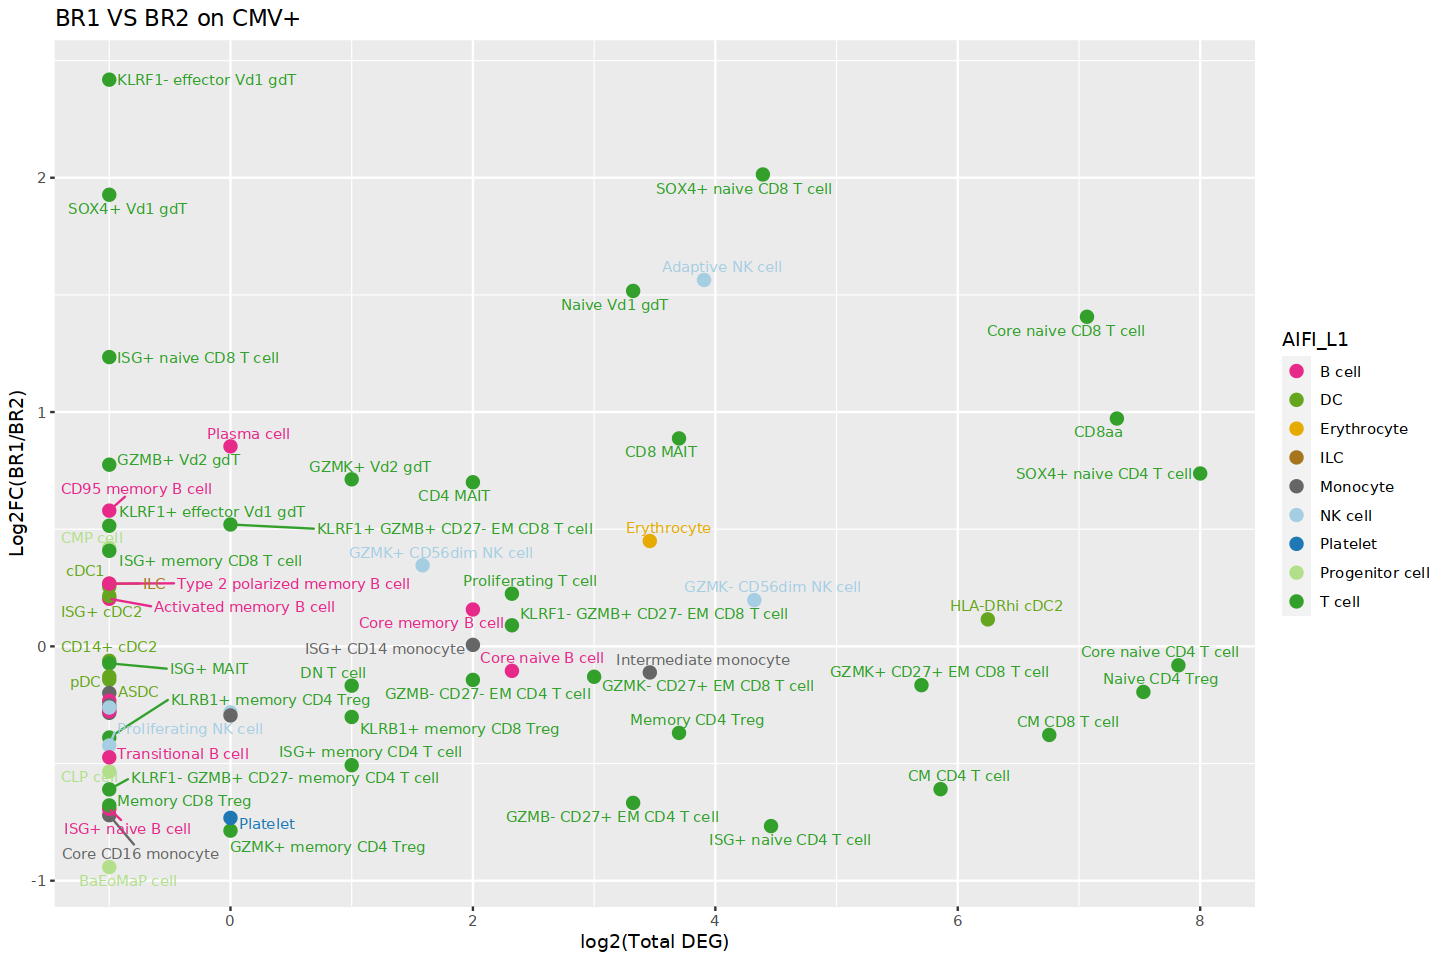

In [92]:
options(repr.plot.width = 12, repr.plot.height = 8)

ggplot(log2FC, aes(`log_counts`, `Log2FC(BR1/BR2)`,  color = AIFI_L1),) +
  geom_point(size=3)+ geom_text_repel(aes(label = AIFI_L3,  color = AIFI_L1), size =3)+
xlab('Total DEG')+scale_color_manual(values = colors[9:19])+ggtitle("BR1 VS BR2 on CMV+")+xlab('log2(Total DEG)')


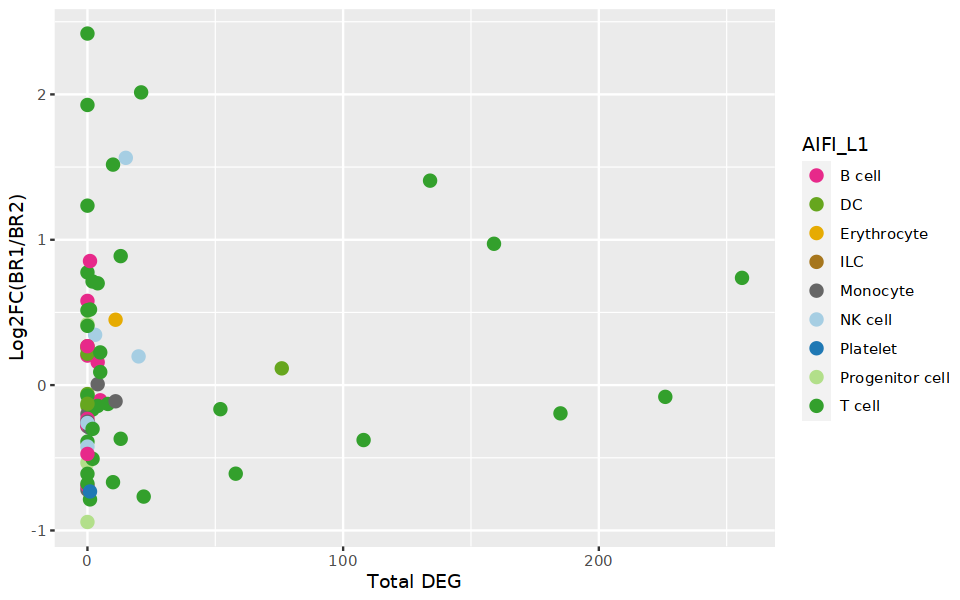

In [93]:
options(repr.plot.width = 8, repr.plot.height = 5)

ggplot(log2FC, aes(`count`, `Log2FC(BR1/BR2)`,  color = AIFI_L1),) +
  geom_point(size=3)+ 
xlab('Total DEG')+scale_color_manual(values = colors[9:19])

# BR1 VS BR2 CMV-

In [94]:
result <- label %>%
  dplyr::group_by(AIFI_L3, subject.subjectGuid) %>%               
  dplyr::summarise(count = n()) %>%                  # Count occurrences
  dplyr::group_by(subject.subjectGuid) %>%                       
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>% 
  dplyr::group_by(subject.subjectGuid) %>%     
  dplyr::mutate(percentage_clr = clr_transform((percentage))) %>% # Group again by subjectGuid for CLR# Calculate percentage
  dplyr::ungroup() %>% as.data.frame(.)

head(result)

`summarise()` has grouped output by 'AIFI_L3'. You can override using the
`.groups` argument.


,AIFI_L3,subject.subjectGuid,count,percentage,percentage_clr
,<chr>,<chr>,<int>,<dbl>,<dbl>
1,ASDC,BR1001,6,0.03236770,-2.232976
2,ASDC,BR1002,5,0.02637409,-2.242500
3,ASDC,BR1003,4,0.02094680,-2.763896
4,ASDC,BR1004,3,0.01710571,-2.626914
5,ASDC,BR1005,5,0.02809620,-1.943233
6,ASDC,BR1006,4,0.02300966,-2.337902


## get median per cohorts

In [95]:
meta<-unique(label[c('subject.subjectGuid','cohort.cohortGuid','CMV.IgG.Serology.Result.Interpretation')])

In [96]:
result<-left_join(result,meta)

Joining with `by = join_by(subject.subjectGuid)`


In [97]:
mean_per_group <- result %>%
  group_by(cohort.cohortGuid,AIFI_L3,CMV.IgG.Serology.Result.Interpretation) %>%
  dplyr::summarize(median_value = median(percentage))


`summarise()` has grouped output by 'cohort.cohortGuid', 'AIFI_L3'. You can
override using the `.groups` argument.


In [98]:
mean_per_group<-mean_per_group %>% filter(CMV.IgG.Serology.Result.Interpretation=='Negative')

In [99]:
mean_per_group_BR1<-mean_per_group %>% filter(cohort.cohortGuid=="BR1") %>% arrange(AIFI_L3)
mean_per_group_BR2<-mean_per_group %>% filter(cohort.cohortGuid=="BR2") %>% arrange(AIFI_L3)

In [100]:
mean_per_group_BR1$AIFI_L3==mean_per_group_BR2$AIFI_L3

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

In [101]:
log2FC=as.data.frame(log2(mean_per_group_BR1$median_value/mean_per_group_BR2$median_value))
log2FC$AIFI_L3<-mean_per_group_BR1$AIFI_L3

## get DEG numbers

In [102]:
levels='L3'
file_list<-list.files(path = paste0("./02B_DESeq2_BR1_VS_BR2_",levels,'_on_CMVneg'), pattern = ".csv", all.files = FALSE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = FALSE, include.dirs = TRUE, no.. = FALSE)

In [103]:
DEG_list<-mclapply(file_list,read.csv,mc.cores=length(file_list))
DEG<-do.call(rbind,DEG_list)

In [104]:
DEG<- DEG%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.1 ~ "Up-regulated",
                                                     log2FoldChange <= -0.1 & padj <= 0.1 ~ "Down-regulated",
                                                     TRUE ~ "Unchanged"))

In [105]:
freq <- DEG %>% dplyr::mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.1 ~ "Up-regulated-BR1",
                                                     log2FoldChange <= -0.1 & padj <= 0.1 ~ "Down-regulated-BR1",
                                                     TRUE ~ "Unchanged")) %>% filter(!Expression=='Unchanged')%>%
  dplyr::group_by(celltype) %>%
  dplyr::summarise(count = n())


In [106]:
colnames(freq)[1]<-"AIFI_L3"

## Plotting

In [107]:
Celltypt_dict<-read.csv('cell_types.csv')
colnames(Celltypt_dict)<-c('AIFI_L1','AIFI_L2','AIFI_L3')

In [108]:
log2FC<-left_join(log2FC,freq) %>%
  mutate_all(~replace(., is.na(.), 0))

Joining with `by = join_by(AIFI_L3)`


In [109]:
colnames(log2FC)[1]<-"Log2FC(BR1/BR2)"

In [110]:
log2FC<-left_join(log2FC,Celltypt_dict)

Joining with `by = join_by(AIFI_L3)`


In [111]:
log2FC$log_counts <- ifelse(log2FC$count == 0, -1, log(log2FC$count))

Warning message:
“ggrepel: 34 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


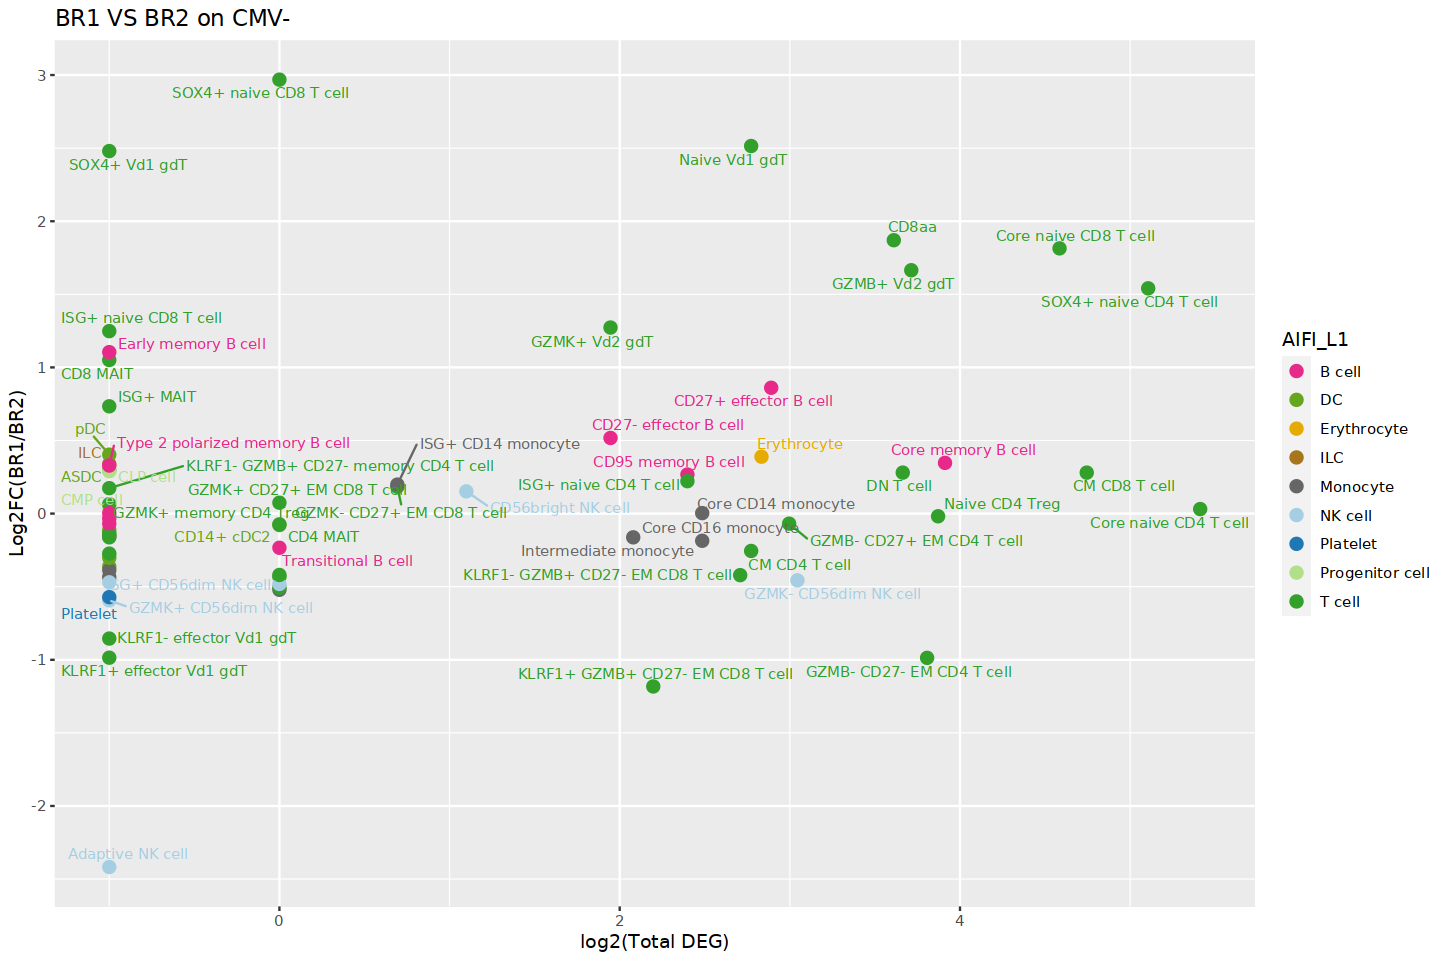

In [114]:
options(repr.plot.width = 12, repr.plot.height = 8)

ggplot(log2FC, aes(`log_counts`, `Log2FC(BR1/BR2)`,  color = AIFI_L1),) +
  geom_point(size=3)+ geom_text_repel(aes(label = AIFI_L3,  color = AIFI_L1), size =3)+
xlab('Total DEG')+scale_color_manual(values = colors[9:19])+ggtitle("BR1 VS BR2 on CMV-")+xlab('log2(Total DEG)')


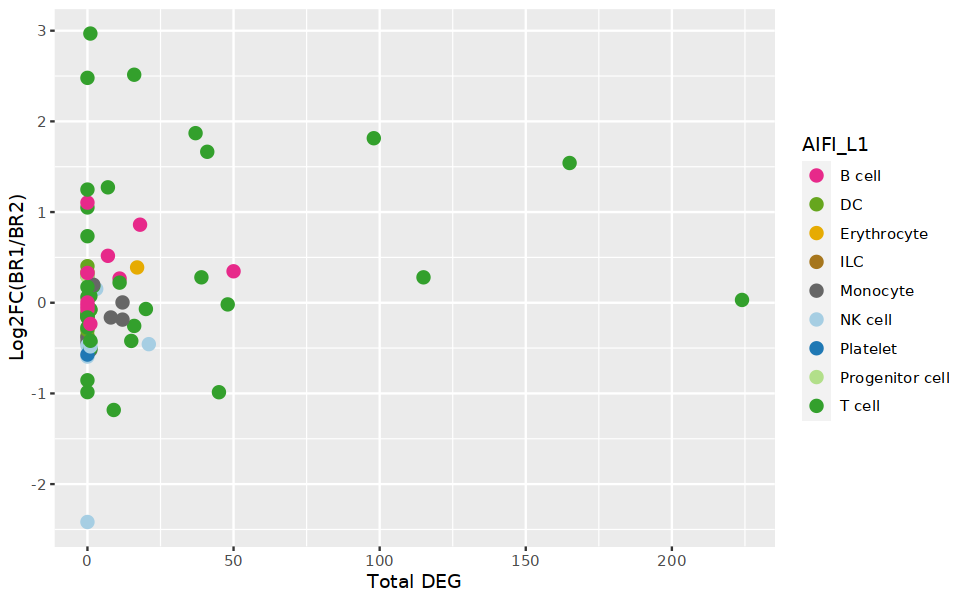

In [113]:
options(repr.plot.width = 8, repr.plot.height = 5)

ggplot(log2FC, aes(`count`, `Log2FC(BR1/BR2)`,  color = AIFI_L1),) +
  geom_point(size=3)+ 
xlab('Total DEG')+scale_color_manual(values = colors[9:19])